In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate

from src.model import tscv, ClippedOutputRegressor
from src.feature_engineering import get_feature_cols, df_to_X_y, drop_non_features

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


Firstly let's load the model we'll be using for our test. I'll be using the baseline model so we have a good comparison with the logged results.

In [2]:
baseline_reg = ClippedOutputRegressor(joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model')))

Now some functions that will help us.

In [3]:
def scores_df(scores):
    return pd.DataFrame({
        'test_score_mean': [np.mean(s['test_score']) for s in scores],
        'test_score_std': [np.std(s['test_score']) for s in scores],
        'test_score_last_fold': [s['test_score'][-1] for s in scores]
    })

def plt_scores(scores_df):
    df = scores_df.copy()
    df['idx'] = df.index
    df = df.melt(value_vars=['test_score_mean', 'test_score_last_fold'], id_vars=['idx'],value_name='neg_RMSE')
    sns.lineplot(data=df, x='idx', y='neg_RMSE', hue='variable')
    
def validate(df, reg_val=baseline_reg, verbose=2, cv_splits=None):
    if not cv_splits:
        cv_splits = tscv.split(df['date_block_num'])
    X_train, y_train = df_to_X_y(df)
    scores = cross_validate(reg_val, X=X_train, y=y_train, 
                            cv=cv_splits, 
                            scoring='neg_root_mean_squared_error', verbose=verbose)
    print("RMSE: %.5f (+- %.5f)" % (np.mean(scores['test_score']), np.std(scores['test_score'])))
    return scores

# Lagged item selection

I'm confident the item counts are highly correlated. Maybe reducing the number of months we get the counts from might help.

In [4]:
train_set_002 = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-features-002.parquet'))
train_set_002.columns

Index(['item_id', 'shop_id', 'date_block_num', 'item_cnt_month',
       'f__item_cnt_1', 'f__item_cnt_2', 'f__item_cnt_3', 'f__item_cnt_4',
       'f__item_cnt_5', 'f__item_cnt_6', 'f__item_cnt_7', 'f__item_cnt_8',
       'f__item_cnt_9', 'f__item_cnt_10', 'f__item_cnt_11', 'f__item_cnt_12',
       'f__item_cnt_13', 'f__item_cnt_14', 'f__item_cnt_15', 'f__item_cnt_16',
       'f__item_cnt_17', 'f__item_cnt_18', 'f__item_cnt_19', 'f__item_cnt_20',
       'f__item_cnt_21', 'f__item_cnt_22', 'f__item_cnt_23', 'f__item_cnt_24',
       'f__item_cnt_25', 'f__item_cnt_26', 'f__item_cnt_27', 'f__item_cnt_28',
       'f__item_cnt_29', 'f__item_cnt_30', 'f__item_cnt_31', 'f__item_cnt_32'],
      dtype='object')

Let's check for the correlation.

In [5]:
def corr_plot(corr_mat, figsize=(10, 10)):
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_mat, mask=np.triu(np.ones_like(corr_mat, dtype=np.bool)),
                square=True, linewidths=.1, cbar_kws={"shrink": .5}, 
                ax=ax, center=0, vmin=-1, vmax=1)

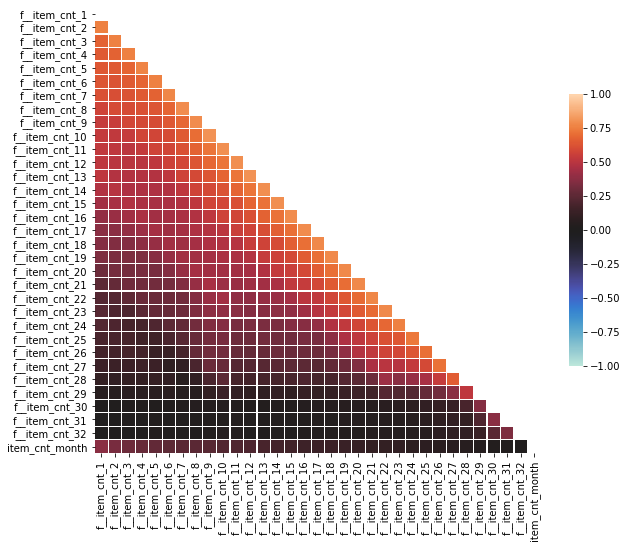

In [6]:
features_corr = train_set_002[np.append(get_feature_cols(train_set_002), ['item_cnt_month'])].corr()
corr_plot(features_corr, figsize=(10, 10))

As expected, a lot of correlation. Let's plot the relationship between validation score and lag window size.

In [17]:
item_cnt_scores = [validate(train_set_002.drop(columns=['f__item_cnt_%d' % i 
                                                        for i in range(lag_lim, 33)]),
                            verbose=0)
                   for lag_lim in trange(2, 33)]

RMSE: -0.89806 (+- 0.05576)
RMSE: -0.88053 (+- 0.06095)
RMSE: -0.87241 (+- 0.06147)
RMSE: -0.87017 (+- 0.06287)
RMSE: -0.86863 (+- 0.06206)
RMSE: -0.86712 (+- 0.06064)
RMSE: -0.86605 (+- 0.06068)
RMSE: -0.86542 (+- 0.06191)
RMSE: -0.86511 (+- 0.06311)
RMSE: -0.86599 (+- 0.06256)
RMSE: -0.86468 (+- 0.06297)


KeyboardInterrupt: 

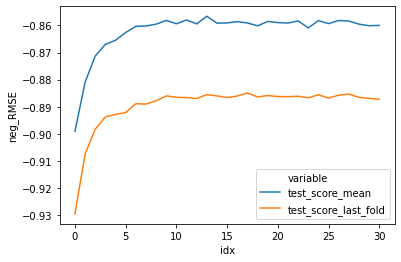

In [52]:
plt_scores(scores_df(item_cnt_scores))

It improves until around 8, but then it doesn't change much. There's also some peaks which indicate some months do add value, so let's try a different approach: for each month, let's validate the dataset without it and see if it improves or not.

In [19]:
item_cnt_drop_scores = [validate(train_set_002.drop(columns=['f__item_cnt_%d' % i]),
                                 verbose=0)
                        for i in trange(1, 33)]

RMSE: -0.91603 (+- 0.07258)
RMSE: -0.87218 (+- 0.06073)
RMSE: -0.86884 (+- 0.06286)
RMSE: -0.86766 (+- 0.06375)
RMSE: -0.86806 (+- 0.06326)
RMSE: -0.86687 (+- 0.06183)
RMSE: -0.86715 (+- 0.06302)
RMSE: -0.86602 (+- 0.06353)
RMSE: -0.86626 (+- 0.06245)
RMSE: -0.86668 (+- 0.06291)
RMSE: -0.86906 (+- 0.06263)
RMSE: -0.86694 (+- 0.06368)
RMSE: -0.86769 (+- 0.06261)
RMSE: -0.86752 (+- 0.06203)
RMSE: -0.86722 (+- 0.06363)
RMSE: -0.86711 (+- 0.06332)
RMSE: -0.86704 (+- 0.06349)
RMSE: -0.86692 (+- 0.06489)
RMSE: -0.86721 (+- 0.06258)
RMSE: -0.86660 (+- 0.06312)
RMSE: -0.86738 (+- 0.06199)
RMSE: -0.86667 (+- 0.06467)
RMSE: -0.86534 (+- 0.06414)
RMSE: -0.86642 (+- 0.06424)
RMSE: -0.86719 (+- 0.06205)
RMSE: -0.86651 (+- 0.06415)
RMSE: -0.86771 (+- 0.06390)
RMSE: -0.86647 (+- 0.06359)
RMSE: -0.86769 (+- 0.06265)
RMSE: -0.86687 (+- 0.06299)
RMSE: -0.86762 (+- 0.06277)
RMSE: -0.86756 (+- 0.06264)



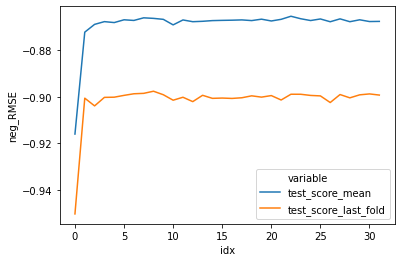

In [22]:
plt_scores(scores_df(item_cnt_drop_scores))

In [30]:
original_score = -0.86796
eps = 0.001
cols_to_drop = [i for i, s in enumerate(item_cnt_drop_scores) if np.mean(s['test_score']) > original_score + eps]

In [31]:
cols_to_drop

[5, 7, 8, 9, 11, 17, 19, 21, 22, 23, 25, 27, 29]

In [32]:
validate(train_set_002.drop(columns=['f__item_cnt_%d' % i for i in cols_to_drop]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ................................................. , total=  12.5s
[CV]  ................................................................
[CV] ................................................. , total=  11.3s
RMSE: -0.86678 (+- 0.06347)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.2s finished


{'fit_time': array([ 9.60526013, 11.65860653, 10.54394102]),
 'score_time': array([0.82388425, 0.80268669, 0.77384043]),
 'test_score': array([-0.77791414, -0.92215417, -0.90026053])}

That's a reeeally tiny improvement, but I'll take it. The other advantage is this reduces the size of the feature set dramatically.